# Generating the RIR Database

The bulk of the RIRs in this database come from the following databases:
* ACE
* AIR
* OpenAIR
* BUT ReverbDB
* Sonos Boston
* Simulated data from PyRoomAcoustics

The process of ingesting this data into a singular .csv file can be found in ```/volume_estimation/processing_notebooks/rir_database.ipynb```, but for sake of convenience we will import the database here. Note that the notebook points to the location of the RIR audio clips, but does NOT inlude the RIR data, so you will need to re-generate this for your own file system.

Note that manually calculating the RT$_{60}$ values with the Schroeder method can be found in the ```processing_notesbooks/rt60_est``` folder.

In [1]:
import os
import numpy as np
import pandas as pd
import librosa as lr
import librosa.display

In [2]:
rir_df = pd.read_csv('data/0812_rir_df.csv')

# Simulating Data

For generating simulated RIRs for specific room volumes, we can use the ```simulation``` sub-module. This is how the RIR simulations in our dataset above are generated.

In [3]:
from volume_estimation import simulation
import pyroomacoustics as pra
from IPython.display import Audio

In [4]:
#generate list of volumes (in m^3) to produce RIRs for:
vols = [100,1000,10000]

#define room materials
m = pra.make_materials(
    ceiling="hard_surface",
    floor="carpet_soft_10mm",
    east="gypsum_board",
    west="gypsum_board",
    north="gypsum_board",
    south="gypsum_board",
)
sr = 16000
n_mics = 3

room_rirs = {}
for vol in vols:
    room_dims = simulation.generate_room_dims(vol)
    room_rirs[vol] = simulation.generate_rirs(room_dims, n_mics, m, sr=sr)   

/scratch/ci411/.conda/envs/s3d_env/lib/python3.8/site-packages/pyroomacoustics/room.py:1019: UserWarning: The number of rays used for ray tracing is larger than100000 which may result in slow simulation.  The numberof rays was automatically chosen to provide accurateroom impulse response based on the room volume and thereceiver radius around the microphones.  The number ofrays may be reduced by increasing the size of thereceiver.  This tends to happen especially for largerooms with small receivers.  The receiver is a spherearound the microphone and its radius (in meters) may bespecified by providing the `receiver_radius` keywordargument to the `set_ray_tracing` method.
  warnings.warn(


In [5]:
Audio(data=room_rirs[100][0], rate=sr)

In [6]:
Audio(data=room_rirs[1000][0], rate=sr)

In [7]:
Audio(data=room_rirs[10000][0], rate=sr)

# Generating Audio

By combining our RIR database along with a speech dataframe (contains filepaths and lengths of the audio clips in seconds) we can generate an audio set by randomly convolving RIRs and audio clips. Note that the dataframes will be uniformly sampled, so draw a distribution you're interested in before passing to the ```generate_rir_audio``` function.

Using the ```out_path``` option to specify the audio output is useful when generating a large volume of data.

You can add SNR augmentation by passing a list of SNRs to the ```snr_list``` argument (this will multiply your outputs by the number of augmentations you do).

In [8]:
from volume_estimation import featurization

In [9]:
speech_df = pd.read_csv('data/ace_speech.csv')

n_samples = 5
rir_sample = rir_df.sample(10)
snr_list = [np.infty, 10]

audio_df, audio_list = featurization.generate_rir_audio(n_samples, speech_df, rir_sample, sr=sr,\
                                                        snr_list=snr_list, verbose=True, return_audio=True)  

5it [00:08,  1.65s/it]


In [10]:
Audio(data=audio_list[0], rate=sr)

# Featurization

The abstract ```_featurizer``` class sets the key definitions of a featurizer object. A few implementations of this class include many of the magnitude-based features used in prior works, but the main one for this study is ```gammatone_featurizer```, which can be used to define magnitude and phase based features, as well as derivatives of both in the frequency/time axes.

To initialize the ```gammatone_featurizer``` object, you must specifiy the input audio length (```input_len```) and the feature type, either ```"mag"``` for magnitude, or ```"phase"``` for phase features. Other hyper parameters include

* ```num_freq``` - number of frequencies
* ```window_s``` - size of the windowing function (samples)
* ```hop_s``` - hop size (samples)
* ```low_freq``` and ```high_freq``` - frequency bounds
* ```deriv_seq``` - any derivatives of the resulting spectrogram. ```0``` refers to the frequency axis, and ```1``` refers to the time axis, so the sequence ```[0,1]``` would be a derivative along the frequency axis, and then a second partial derivative along the time axis (a.k.a continuity).

To stack multiple features together, use the ```featurizer_block``` implementation of the abstract ```_featurizer``` class. An example is shown below.

To generate features in bulk, the ```process_features``` function is useful, as it also generates a dataframe which it saves to ```feature_df.csv``` which includes target labels and paths to the feature file.

mag features output shape: (20, 1997)
phase features output shape: (5, 1997)
phase features output shape: (5, 1997)
Featurization block output shape: (30, 1997)


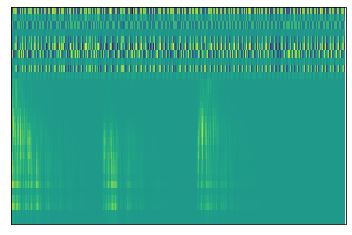

In [11]:
sr = 16000
sample_audio = audio_list[0]

#define featurizer
input_shape = len(sample_audio)

mag_fb = featurization.gammatone_featurizer(input_shape, 'mag')

phase_lf = featurization.gammatone_featurizer(input_shape, 'phase', num_freq=5,
                               low_freq=50, high_freq=500)

phase1D_lf = featurization.gammatone_featurizer(input_shape, 'phase', num_freq=5,
                               low_freq=50, high_freq=500, deriv_seq=[0])


feat_block = featurization.featurizer_block(input_shape, featurizations=[mag_fb, phase_lf, phase1D_lf])

sample_feature =feat_block.process(sample_audio)

_ = lr.display.specshow(sample_feature, cmap='viridis')

# Modeling

Once our features are generated, the modeling process is relatively straightforward. The function ```train_model``` from the ```modeling``` sub-module can be used for efficient deployment of models. To initialize it, a dictionary containing the following keys is needed:

* ```"name"``` - the name of the model
* ```"notes"``` - any notes on the details of this model (can be left blank)
* ```"data_path"``` - a path pointing to the feature dataframe generated in the featurization step
* ```"model_path"``` - The path in which the model's training history, weights, specification, etc. wil be stored

The ```train_model``` function has a variety of inputs, most of which are hyerparameters:

* ```model_func``` - the constructor of the model architecture we're training (default is ```Baseline_Model```)
* `model_dict` - the dictionary defined above
* `log` - boolean of if to train on the log-scaled target variable
* `target` - the value to train on, will typically be `'vol'` or `'rt60'` for the sake of this study.

This training function will provide a constantly updated model state/history file in the model directory. At the end of training, it will also compute metrics on each of the 

In [12]:
from volume_estimation import modeling

Using device: cpu
Using device: cpu



In [13]:
MODELS_DIR = '/scratch/ci411/sonos_rirs/models/'
FEATURES_DIR = '/scratch/ci411/sonos_rirs/features/'
#adjust these variables for your own file system

feature_set = '081522_20k/081522_20k_prop1'

model_dict = {}
model_dict['name'] = 'prop1_20k_081622'
model_dict['notes'] = 'Model proposition 1, best model, mag + lf phase + lf phase 1st deriv'
model_dict['data_path'] = os.path.join(FEATURES_DIR, feature_set, 'feature_df.csv')
model_dict['model_path'] = os.path.join(MODELS_DIR, '20k_comp_models', model_dict['name'])

while False: # this will take too long
    modeling.train_model(modeling.Baseline_Model, model_dict, epochs=1000, batch_size=128, lr_init=1.85e-05, l2_reg=0.00167, overwrite=True, log=True, sched_thres=0.001)


For sake of example, a copy of several models have been stored to `demo_model` in the root directory of this project. You can use the ```plot_experiment_curves``` to examine the training curves of the models (including while they're running), and the ```plot_experiment_metrics``` to compare key performance metrics across different datasets

In [19]:
from volume_estimation import evaluation

Model prop0_20k_081622 has completed 1000 epochs
Model prop1_20k_081622 has completed 1000 epochs
Model prop2_20k_081622 has completed 1000 epochs
Model prop3_20k_081622 has completed 1000 epochs
Model prop4_20k_081622 has completed 1000 epochs
Model prop5_20k_081622 has completed 1000 epochs
Model prop6_20k_081622 has completed 1000 epochs


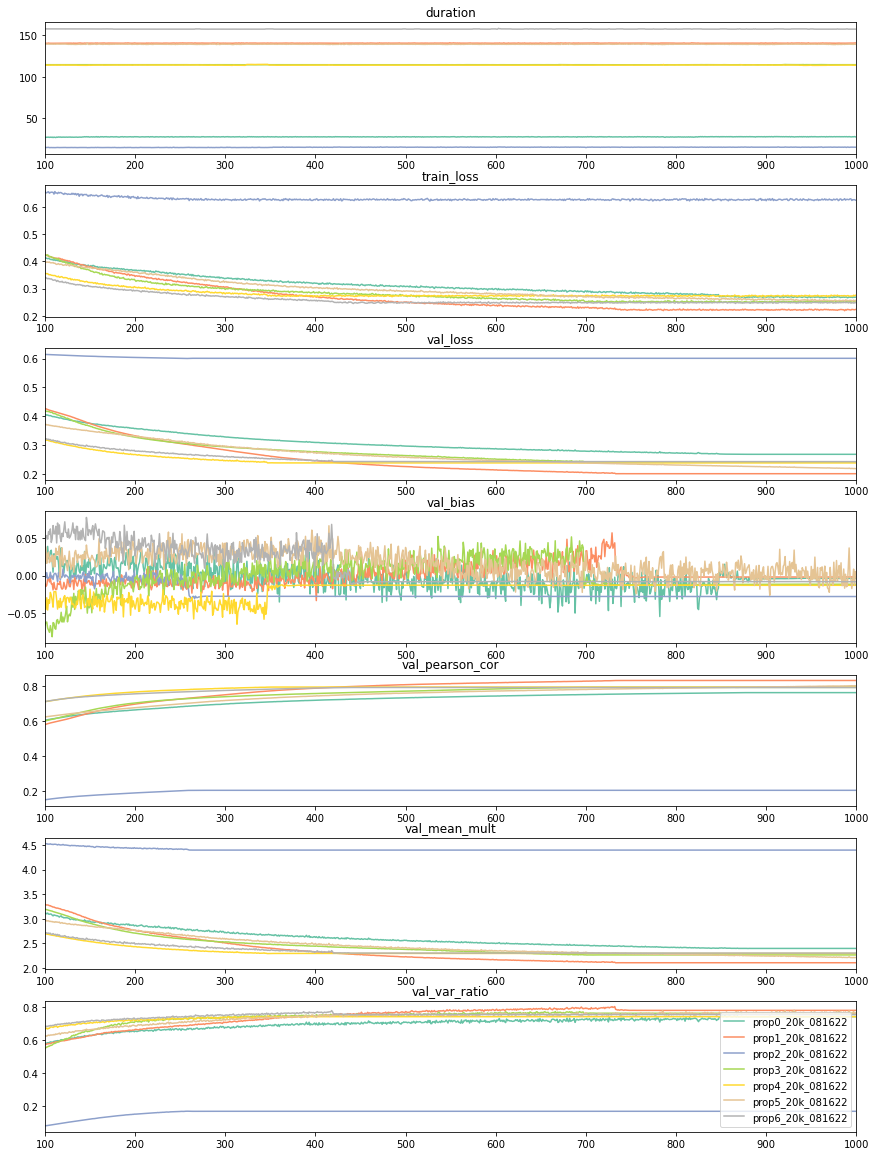

In [20]:
experiment_name = '0816_models'
models_dir = 'demo_models'
fig_curves = evaluation.plot_experiment_curves(experiment_name, offset=100, cmap='Set2', models_dir=models_dir)

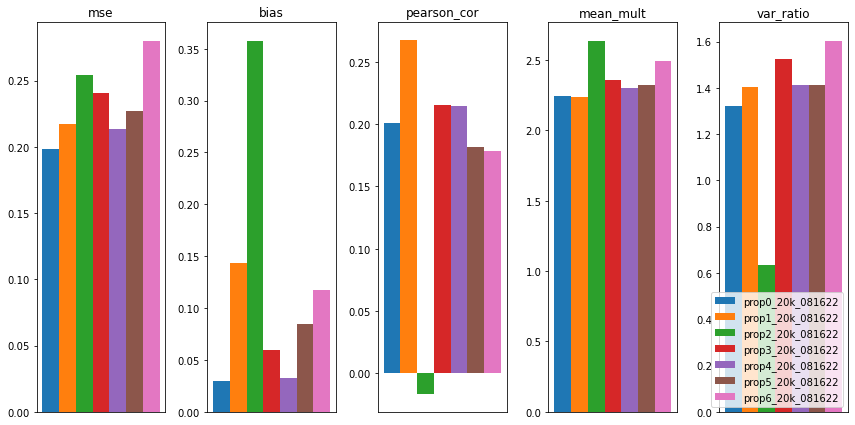

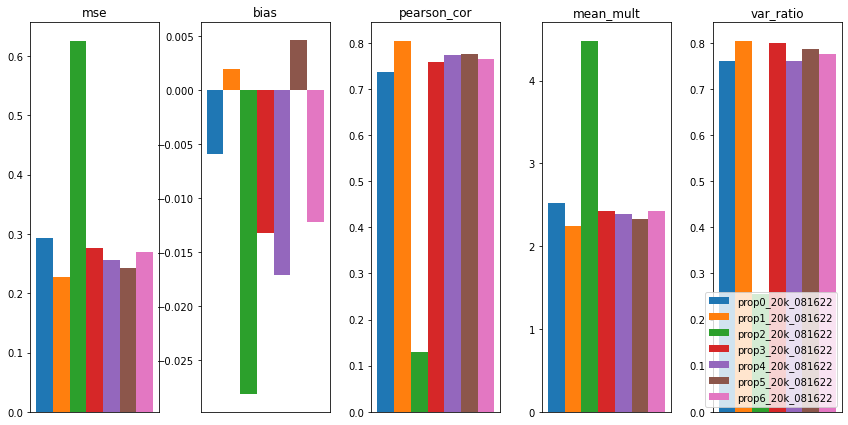

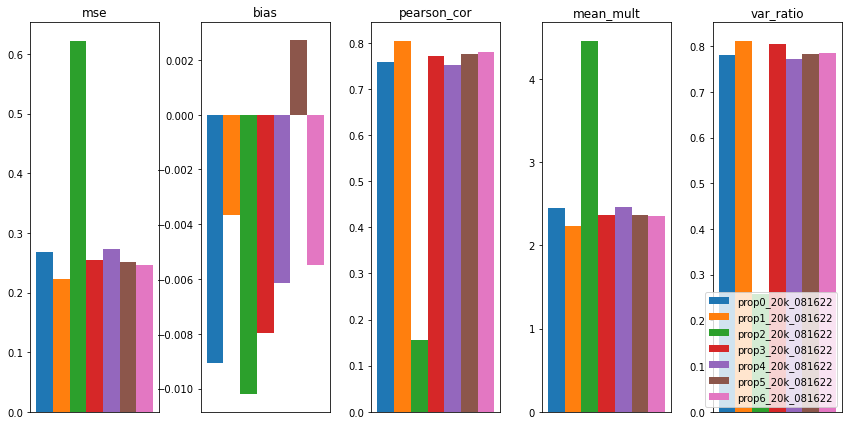

In [21]:
test_metrics = evaluation.plot_experiment_metrics(experiment_name, split='test', models_dir=models_dir)
val_metrics = evaluation.plot_experiment_metrics(experiment_name, split='val', models_dir=models_dir)
train_metrics = evaluation.plot_experiment_metrics(experiment_name, split='train', models_dir=models_dir)